In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import glob
import re
from matplotlib import colors

#for event display
import sys
#path to event display directory - change with where your path is 
# sys.path.append("C:/Users/ms2609/Downloads/WCTE_event_display-main/")
import EventDisplay
import matplotlib.colors as colors
from platform import python_version
print(python_version())

3.11.5


## Load in data

Loads in the data, break in the loop to only load the first 10 files - can be tuned to look at specific files. Notebook will crash if too much data is loaded - loading only hits and not waveforms is an option to reduce memory

In [2]:
runNumber = 1489
#f'../data/2025_LaserBall/WCTE_offline_R{run}S*P*.root'
file_pattern = "../WCTE_offline_R"+str(runNumber)+"S0P*.root"
file_list = glob.glob(file_pattern)
print (file_list)

def extract_p_number(file_name):
    match = re.search(r'P(\d+)\.root$', file_name)  # Extract number after 'P'
    return int(match.group(1)) if match else float('inf')  # Convert to int, default high if no match

file_list = sorted(file_list, key=extract_p_number)
# print(file_list)

all_events_list = []

# Loop over files and load data
for ifile, file_path in enumerate(file_list):
    if ifile>9:
        break
    print(f"Loading: {file_path}")
    
    with uproot.open(file_path) as root_file:
        tree = root_file["WCTEReadoutWindows"]
        events = tree.arrays(library="ak")  # Load branches as awkward arrays
        all_events_list.append(events)  # Store in list

# Concatenate everything into a single awkward array
if all_events_list:
    all_events = ak.concatenate(all_events_list,axis=0)

print(f"Total events loaded: {len(all_events)}")

['..\\WCTE_offline_R1489S0P0.root']
Loading: ..\WCTE_offline_R1489S0P0.root
Total events loaded: 1779


## Load event display of N events

In [13]:
#event_no gives offset in file for event to look at
event_no = 1
#number of events to integrate when summing/averaging event display data
nEvents_to_show = 1
event = all_events[event_no]
pmt_id = ak.to_numpy(ak.zeros_like(((event['hit_mpmt_slot_ids']*19)+event['hit_pmt_position_ids'])[event['hit_mpmt_card_ids']<120]))
data_to_plot = ak.to_numpy(ak.zeros_like(event['hit_pmt_charges'][event['hit_mpmt_card_ids']<120]))



In [14]:
print("Look at", nEvents_to_show, "events" )
counter = 0
for event in all_events:
    counter = counter + 1
    if counter > nEvents_to_show:
        break
    #if occurs in first 10ms missing hits are expected
    # print("Is in first 10ms of 67ms?",event["window_time"]%67108864,event["window_time"]%67108864<1e7)
    temp_id = ak.to_numpy(((event['hit_mpmt_slot_ids']*19)+event['hit_pmt_position_ids'])[event['hit_mpmt_card_ids']<120])
    pmt_id = np.concatenate((pmt_id, temp_id))

    temp_data = ak.to_numpy(event['hit_pmt_charges'][event['hit_mpmt_card_ids']<120])
    data_to_plot = np.concatenate((data_to_plot, temp_data))

Look at 1 events


[ 0  0  0 ... 14 15 16]
(2014,)


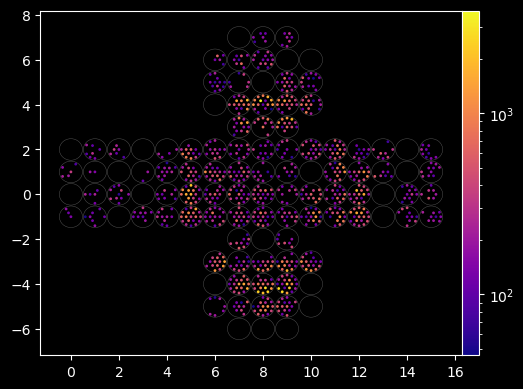

In [16]:
eventDisplay = EventDisplay.EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')

#process data has a sum_data option set to true by default, which sums the quantity for each PMT over all events passed to display
# if set to false it will only plot the smallest quantity for each PMT e.g. time 
# average data will try to take the average of data per PMT where there are a certain number of hits above threshold (set in the display code)
ev_disp_data = eventDisplay.process_data(pmt_id,data_to_plot,sum_data=False, average_data=False)

# eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.Normalize(), style= "dark_background")
eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.LogNorm(), style= "dark_background")
plt.show(block=False)
plt.style.use('default') 